## Data Analysis Workshop
Tutorial III: Accessing Data on S3

This tutorial is similar to the first one! However we’ll learn how to use `xarray`, `zarr` and `s3fs` to explore datasets available via S3 but also upload results to it!

To get started, we’ll run a simple analysis on a remote (NCAR AWS S3) collection.

In [1]:
from freva_client import databrowser

In [2]:
databrowser.metadata_search(fs_type="s3")

{'ensemble': ['r1i1p1f1'],
 'experiment': ['historical', 'ssp370'],
 'institute': ['ncar'],
 'model': ['cesm2-le'],
 'product': ['output'],
 'project': ['cesm2-le'],
 'realm': ['atm', 'ice', 'lnd', 'ocn'],
 'time_aggregation': ['mean'],
 'time_frequency': ['daily', 'monthly', 'static'],
 'variable': ['aice',
  'aice_d',
  'dic',
  'doc',
  'flns',
  'flnsc',
  'flut',
  'fsno',
  'fsns',
  'fsnsc',
  'fsntoa',
  'h2osno',
  'hi',
  'hi_d',
  'icefrac',
  'lhflx',
  'npp',
  'o2',
  'pd',
  'precc',
  'precl',
  'precsc',
  'precsl',
  'ps',
  'psl',
  'q',
  'qrunoff',
  'rain',
  'salt',
  'shflx',
  'snow',
  'soilliq',
  'soilwater_10cm',
  't',
  'temp',
  'tmq',
  'trefht',
  'trefhtmn',
  'trefhtmx',
  'trefmxav',
  'ts',
  'u',
  'ues',
  'uet',
  'uvel',
  'v',
  'vns',
  'vnt',
  'vvel',
  'wts',
  'wtt',
  'wvel',
  'z3']}

In [3]:
search_keys = {
    'fs_type': 's3',
    'project':'cesm2-le',
    'experiment': 'historical',
    'realm': 'atm',
    'time_frequency':'monthly'
}
'ts' in databrowser.metadata_search(**search_keys)['variable']

True

In [4]:
db = databrowser(variable='ts', **search_keys)
list(db)

['s3://ncar-cesm2-lens/atm/monthly/cesm2LE-historical-smbb-TS.zarr',
 's3://ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-TS.zarr']

## Let's quickly check how to open the first dataset with xarray

Since all are zarr datasets we can use `xr.open_zarr` or `xr.open_dataset(engine='zarr')`.

Because the data is public, we do not need credentials to open the data. We specify `anon` (anonymous) in order for xarray to not sign the requests.

If data is **not** public we will get `403 Forbidden`

In [5]:
import xarray as xr
xr.open_zarr(list(db)[0], storage_options={ 'anon':True })
xr.open_dataset(list(db)[0], engine='zarr', storage_options={ 'anon':True })

<xarray.Dataset> Size: 22GB
Dimensions:    (member_id: 50, time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, nbnd) object 32kB ...
Dimensions without coordinates: nbnd
Data variables:
    TS         (member_id, time, lat, lon) float32 22GB ...
Attributes:
    Conventions:       CF-1.0
    logname:           sunseon
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  month_1
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...

In [6]:
import xarray as xr
import numpy as np
def field_mean(
    data: xr.DataArray,
    lat_name: str = "lat",
    lon_name: str = "lon",
    mean_dims: tuple[str, str] = ("lat", "lon")
) -> xr.DataArray:
    """
    Compute an area-weighted mean over latitude and longitude using cosine latitude weights.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with latitude and longitude coordinates.
    lat_name : str, optional
        Name of the latitude coordinate. Default is "lat".
    lon_name : str, optional
        Name of the longitude coordinate. Default is "lon".
    mean_dims : Sequence[str], optional
        Dimensions over which to compute the mean. Default is ("lat", "lon").

    Returns
    -------
    xr.DataArray
        Area-weighted mean of the input data over the specified dimensions.
    """
    # Extract latitude values
    lat = data[lat_name]

    # Compute cosine of latitude in radians
    weights = np.cos(np.deg2rad(lat))

    # Normalize weights so they sum to 1 (over just lat)
    weights /= weights.sum()

    # Apply weighted mean over specified dimensions
    return data.weighted(weights).mean(dim=mean_dims, keep_attrs=True)

In [7]:
from pathlib import Path
s3_opts = { 'anon':True }
time_series = {}

for fileurl in db:
    print(f"Opening {fileurl}...")
    engine = {'engine':'zarr'} if fileurl.endswith('zarr') else {}
    ds = xr.open_dataset(fileurl, **engine, storage_options=s3_opts)
    ds = ds.rename({'member_id':'ensemble'})
    
    # Going through all ensembles might take some time
    # let's make a cut at 5 member for demo purposes
    # Memory usage might spike to ~70GB 
    members=ds.ensemble[:5]
    ds = ds.sel(ensemble=members)    
    
    dataset_name=Path(fileurl).stem   
    
    mean_ts = field_mean(ds["TS"])
    mean_ts.attrs['source_dataset'] = fileurl
    time_series[dataset_name] = mean_ts
   

Opening s3://ncar-cesm2-lens/atm/monthly/cesm2LE-historical-smbb-TS.zarr...
Opening s3://ncar-cesm2-lens/atm/monthly/cesm2LE-historical-cmip6-TS.zarr...


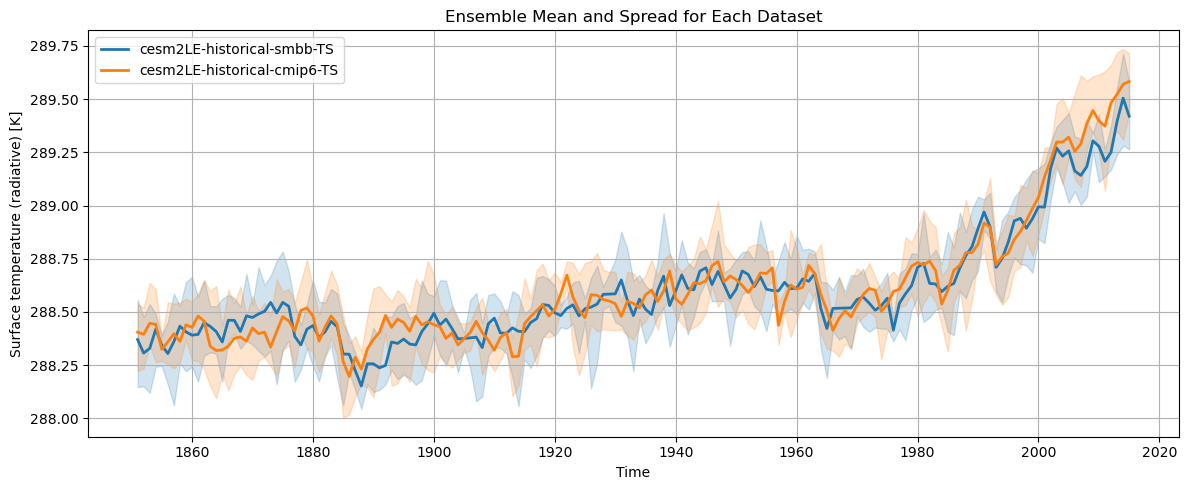

In [8]:
import matplotlib.pyplot as plt

# Create a color cycle for different experiments
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plot = plt.figure(figsize=(12, 5))

for i, (exp, data) in enumerate(time_series.items()):
    ts = data.resample(time="1YE").mean()
    ts_min = ts.min(dim="ensemble").squeeze()
    ts_max = ts.max(dim="ensemble").squeeze()
    ts_mean = ts.mean(dim="ensemble").squeeze()
    time_str = ts.time.dt.strftime("%Y").values
    time_values = np.array(ts.time.values, dtype='datetime64[ns]')
    # Plot min–max shading
    plt.fill_between(
        time_values,
        ts_min.values,
        ts_max.values,
        color=colors[i % len(colors)],
        alpha=0.2,
        label=None,
    )
    # Plot mean line
    plt.plot(
        time_values,
        ts_mean.values,
        color=colors[i % len(colors)],
        linewidth=2,
        label=f"{exp}"
    )

# Add plot decorations
plt.title("Ensemble Mean and Spread for Each Dataset")
plt.xlabel("Time")
plt.ylabel(f"{data.attrs['long_name']} [{data.attrs['units']}]")  # Replace with actual units
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

----

# Let's save the plot on S3, as well as the datasets!

We start by setting up a dictionary with the configuration we will need.

In [9]:
from getpass import getuser # to get USER env variable
USERNAME = getuser()
s3_config = {
    'bucket' : 'freva',
    'endpoint' :'https://s3.eu-dkrz-1.dkrz.cloud', # DKRZ Minio S3
    'prefix' : f'workshop/{USERNAME}', # Avoid users writting object with same prefix
    'access_key_id' : "s3handson", # Only valid during the workshop
    'secret_access_key' : "s3handson", # Only valid during the workshop
    'region' : 'eu-dkrz-1',
}

Now we create a wrapper on S3 that mimics a local filesystem. This will be important for `netcdf`

In [10]:
import s3fs
s3 = s3fs.S3FileSystem(
    key=s3_config['access_key_id'],
    secret= s3_config['secret_access_key'],
    endpoint_url = s3_config['endpoint'],
)

full_prefix = s3_config['bucket']+'/'+s3_config['prefix'] 
testobj=f'{full_prefix}/hi.txt'
s3.write_bytes(testobj, b'Hi!\n')

print(f"Writing data to S3 works! Test it with:\ncurl {s3_config['endpoint']}/{testobj}")

Writing data to S3 works! Test it with:
curl https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/hi.txt


In [11]:
!curl https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/${USER}/hi.txt

Hi!


### Save the figure on S3
 - Open the object ("file") on S3 where the figure should be saved
 - Save the figure into that opened object!

In [12]:
figure_path = f'{full_prefix}/figure-ts-mean.png'
with s3.open(figure_path, 'wb') as f:
    plot.savefig(f)
print(f"Open this link to get the image: {s3_config['endpoint']}/{figure_path}")

Open this link to get the image: https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/figure-ts-mean.png


### Let's now write the data to S3 as both NetCDF and ZARR

Note that since we are writting to an object store we cannot opened file to `xr.to_netcdf` because `seek` operations are not supported!

In that case that case simply copy the file.

In [13]:
def write_netcdf(s3_path, dataset:xr.Dataset):
    tmp_name=f"/scratch/{USERNAME[0]}/{USERNAME}/{name}.nc"
    dataset.to_netcdf(tmp_name, engine='h5netcdf')
        
    ## Copy to s3
    with s3.open(s3_path,'wb') as s3file:
        with open(tmp_name, 'rb') as tmpf:
            s3file.write(tmpf.read())

    ## Check if we can open with Xarray and CDO!
    with s3.open(s3_path,'rb') as s3file:
        xr.open_dataset(s3file, engine='h5netcdf')
    
    ## We can now remove the local copy
    import os
    os.remove(tmp_name)

In [14]:
def write_zarr(store, dataset: xr.Dataset):     
    import zarr
    zarr.config.set(default_zarr_format=2)
    
    import numcodecs
    codec = numcodecs.Blosc(shuffle=1, clevel=6)
    
    data_encoding = {}
    for var in dataset.variables:
        data_encoding[var] = { "compressors": codec}

    dataset.to_zarr(store,
                    mode='w', # OVERWRITES existing data!!
                    encoding=data_encoding,
                    consolidated=True, # consolidate metadata for fast access
                    storage_options= { # We cannot use the anonymous mode anymore
                        'key':s3_config['access_key_id'], 
                        'secret':s3_config['secret_access_key'],
                        'endpoint_url': s3_config['endpoint'],
                    })

In [15]:
def write_dataset_to_s3(name:str, dataset:xr.Dataset, file_format='nc'):
    _supported_types = ('nc','zarr')
    file_format = file_format.replace('.','')
    if file_format not in _supported_types:
        raise Exception('Unsuported file format, use one of')
    
    s3_path = f'{full_prefix}/{name}.{file_format}'
    if file_format == 'nc':
        write_netcdf(s3_path, dataset)

    elif file_format == 'zarr':
        write_zarr(f's3://{s3_path}', dataset)

    netcdf_mode= 'zarr' if file_format == 'zarr' else 'bytes'
    print(f"Try running:\n\t" \
          f"/fastdata/k20200/k202186/public/bin/ncdump -h {s3_config['endpoint']}/{s3_path}#mode=s3,{netcdf_mode}\n\t"\
          f"/fastdata/k20200/k202186/public/bin/cdo sinfo {s3_config['endpoint']}/{s3_path}#mode=s3,{netcdf_mode}")
    

We save the mean temperature array in S3 as both Zarr and NetCDF

In [16]:
for name, data in time_series.items():
    ## for CDO it is important that time is the first dimension
    ## also it cannot have indexers of type string
    ensemble = data.ensemble.values
    ensemble_id = np.arange(len(ensemble))
    
    dataset = data.to_dataset() \
            .transpose('time',...) \
            .assign_coords(ensemble_id=('ensemble',ensemble_id)) \
            .swap_dims({'ensemble':'ensemble_id'}) \
            .reset_coords(drop=True)\
            .assign_attrs(ensembles= ', '.join(data.ensemble.values))
    
    write_dataset_to_s3(name, dataset, file_format='nc')
    write_dataset_to_s3(name, dataset, file_format='zarr')

public_url = f"https://eu-dkrz-1.dkrz.cloud/browser/{s3_config['bucket']}/{s3_config['prefix']}"
f"{s3_config['endpoint']}/browser/{s3_config['bucket']}/{s3_config['prefix']}"
print(f"Browser the data in {public_url}")

Try running:
	/fastdata/k20200/k202186/public/bin/ncdump -h https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/cesm2LE-historical-smbb-TS.nc#mode=s3,bytes
	/fastdata/k20200/k202186/public/bin/cdo sinfo https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/cesm2LE-historical-smbb-TS.nc#mode=s3,bytes
Try running:
	/fastdata/k20200/k202186/public/bin/ncdump -h https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/cesm2LE-historical-smbb-TS.zarr#mode=s3,zarr
	/fastdata/k20200/k202186/public/bin/cdo sinfo https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/cesm2LE-historical-smbb-TS.zarr#mode=s3,zarr
Try running:
	/fastdata/k20200/k202186/public/bin/ncdump -h https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/cesm2LE-historical-cmip6-TS.nc#mode=s3,bytes
	/fastdata/k20200/k202186/public/bin/cdo sinfo https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/k202186/cesm2LE-historical-cmip6-TS.nc#mode=s3,bytes
Try running:
	/fastdata/k20200/k202186/public/bin/ncdump -h https://s3.eu-dkrz-1.

In [17]:
!/fastdata/k20200/k202186/public/bin/ncdump -h https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/$USER/cesm2LE-historical-smbb-TS.nc#mode=s3,bytes
!/fastdata/k20200/k202186/public/bin/cdo sinfo https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/$USER/cesm2LE-historical-smbb-TS.nc#mode=s3,bytes

netcdf cesm2LE-historical-smbb-TS {
dimensions:
	time = 1980 ;
	ensemble_id = 5 ;
variables:
	double time(time) ;
		time:_FillValue = NaN ;
		string time:units = "days since 1850-01-01" ;
		string time:calendar = "noleap" ;
	double TS(time, ensemble_id) ;
		TS:_FillValue = NaN ;
		string TS:cell_methods = "time: mean" ;
		string TS:long_name = "Surface temperature (radiative)" ;
		string TS:units = "K" ;
		string TS:source_dataset = "s3://ncar-cesm2-lens/atm/monthly/cesm2LE-historical-smbb-TS.zarr" ;
	int64 ensemble_id(ensemble_id) ;

// global attributes:
		string :ensembles = "r10i1191p1f2, r11i1231p1f2, r11i1251p1f2, r11i1281p1f2, r11i1301p1f2" ;
}
   File format : NetCDF4
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  v instant       1   1         5   1  F64  : -1            
   Grid coordinates :
     1 : generic                  : points=5
                      ensemble_id : 0 to 4 by 1
   Vertical coordinates :
    

In [18]:
!/fastdata/k20200/k202186/public/bin/ncdump -h https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/$USER/cesm2LE-historical-smbb-TS.zarr#mode=s3,zarr
!/fastdata/k20200/k202186/public/bin/cdo sinfo https://s3.eu-dkrz-1.dkrz.cloud/freva/workshop/$USER/cesm2LE-historical-smbb-TS.zarr#mode=s3,zarr

netcdf cesm2LE-historical-smbb-TS {
dimensions:
	time = 1980 ;
	ensemble_id = 5 ;
variables:
	double TS(time, ensemble_id) ;
		TS:_FillValue = NaN ;
		TS:cell_methods = "time: mean" ;
		TS:long_name = "Surface temperature (radiative)" ;
		TS:units = "K" ;
		TS:source_dataset = "s3://ncar-cesm2-lens/atm/monthly/cesm2LE-historical-smbb-TS.zarr" ;
	int64 ensemble_id(ensemble_id) ;
	int64 time(time) ;
		time:units = "hours since 1850-01-16 12:00:00.000000" ;
		time:calendar = "noleap" ;

// global attributes:
		:ensembles = "r10i1191p1f2, r11i1231p1f2, r11i1251p1f2, r11i1281p1f2, r11i1301p1f2" ;
}
   File format : NCZarr filter
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  v instant       1   1         5   1  F64f : -1            
   Grid coordinates :
     1 : generic                  : points=5
                      ensemble_id : 0 to 4 by 1
   Vertical coordinates :
     1 : surface                  : levels=1
   Time coor